In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

class L1RegularizedLogisticRegression:
    def __init__(self, learning_rate=0.01, lambda_param=1.0):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.theta = None
        self.u = 0  # Cumulative L1 penalty
        self.q = None  # Cumulative applied penalty for each feature

    def sigmoid(self, z):
        z = np.array(z, dtype=np.float64)
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def initialize(self, X):
        n_features = X.shape[1]
        self.theta = np.zeros(n_features + 1, dtype=np.float64)
        self.q = np.zeros(n_features + 1, dtype=np.float64)

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        X = X.astype(np.float64)
        y = y.astype(np.float64)

        self.initialize(X)
        m, n = X.shape
        X_with_bias = np.column_stack([np.ones(m, dtype=np.float64), X])

        for j in range(m):
            self.update_weights(X_with_bias[j], y[j])
            self.u += self.learning_rate * self.lambda_param / m

    def update_weights(self, x_j, y_j):
        h = self.sigmoid(np.dot(self.theta, x_j))
        gradient = (h - y_j) * x_j

        for i in range(len(self.theta)):
            if x_j[i] != 0:
                self.theta[i] -= self.learning_rate * gradient[i]
                self.apply_penalty(i)

    def apply_penalty(self, i):
        z = self.theta[i]
        if self.theta[i] > 0:
            self.theta[i] = max(0, self.theta[i] - (self.u + self.q[i]))
        elif self.theta[i] < 0:
            self.theta[i] = min(0, self.theta[i] + (self.u - self.q[i]))
        self.q[i] += self.theta[i] - z

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        X = X.astype(np.float64)
        X_with_bias = np.column_stack([np.ones(X.shape[0], dtype=np.float64), X])
        prob = self.sigmoid(np.dot(X_with_bias, self.theta))
        return (prob >= 0.5).astype(int)

In [69]:
def select_lambda_l1(X_train, y_train, X_val, y_val, lambda_values):
    best_lambda = None
    best_accuracy = -np.inf
    for lambda_param in lambda_values:
        model = L1RegularizedLogisticRegression(lambda_param=lambda_param)
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred_val)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lambda = lambda_param
    return best_lambda

In [70]:
from sklearn.model_selection import train_test_split

def load_and_split_data(filepath, target_col, test_size=0.1, val_size=0.1):
    data = pd.read_csv(filepath)
    y = data[target_col]
    X = data.drop([target_col], axis=1)

    # Handle categorical variables
    if "famhist" in X.columns:
        X = pd.get_dummies(X, columns=["famhist"], drop_first=True)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [71]:
def lasso_path(X, y, lambda_values):
    n_features = X.shape[1]
    coef_path = np.zeros((len(lambda_values), n_features))
    for i, lambda_param in enumerate(lambda_values):
        model = L1RegularizedLogisticRegression(lambda_param=lambda_param)
        model.fit(X, y)
        coef_path[i] = model.theta[1:]  # Exclude the bias term
    return coef_path

def plot_lasso_path(lambda_values, coef_path, feature_names):
    plt.figure(figsize=(12, 8))
    for i in range(coef_path.shape[1]):
        plt.plot(np.log(lambda_values), coef_path[:, i], label=feature_names[i])
    plt.xlabel('log(lambda)')
    plt.ylabel('Coefficients')
    plt.title('LASSO Path')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

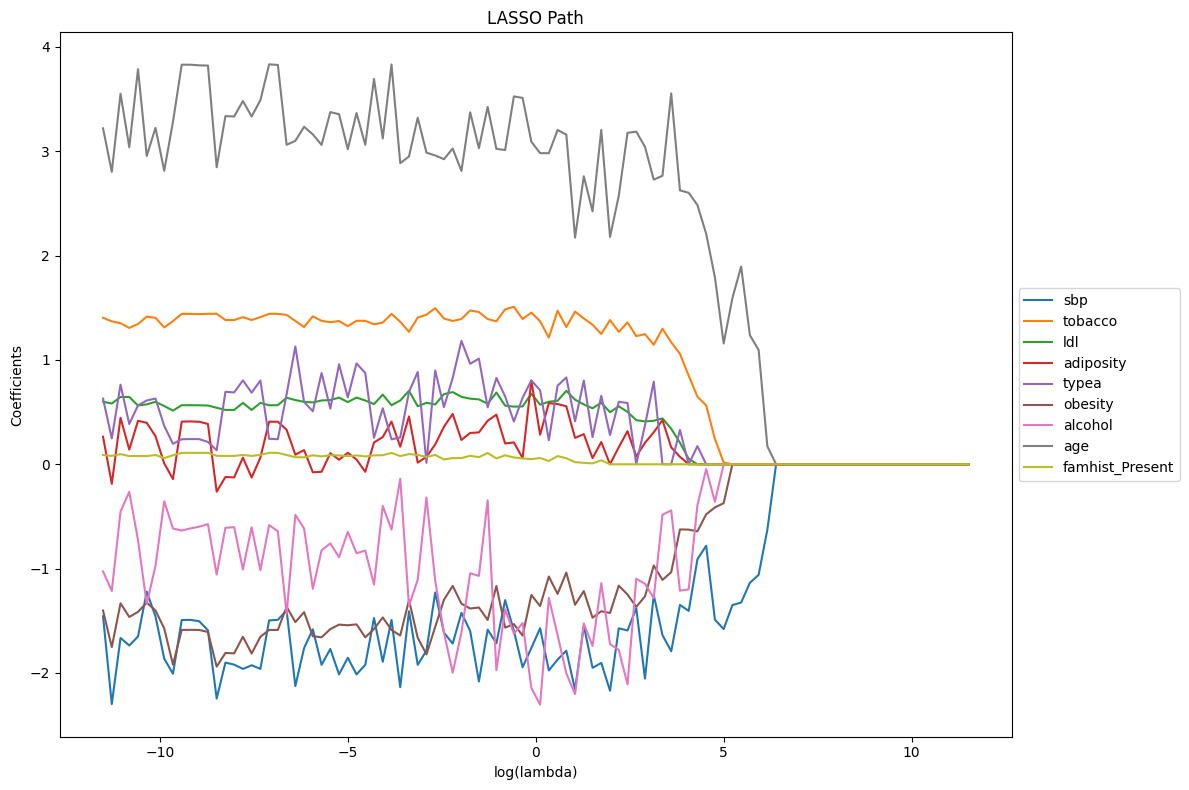

L1 Regularized Model Accuracy: 0.7021
Most important features: ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Present']


In [72]:
from sklearn.metrics import accuracy_score

X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data("data/south_african_heart_disease.csv", "chd")

lambda_values = np.logspace(-5, 5, 100)

best_lambda = select_lambda_l1(X_train, y_train, X_val, y_val, lambda_values)


l1_model = L1RegularizedLogisticRegression(lambda_param=best_lambda)
l1_model.fit(X_train, y_train)

l1_y_pred_test = l1_model.predict(X_test)
l1_accuracy = accuracy_score(y_test, l1_y_pred_test)

# Generate LASSO path
coef_path = lasso_path(X_train, y_train, lambda_values)

# Plot LASSO path
plot_lasso_path(lambda_values, coef_path, X_train.columns)

# Determine most important features
important_features = X_train.columns[np.abs(l1_model.theta[1:]) > 0].tolist()

print(f"L1 Regularized Model Accuracy: {l1_accuracy:.4f}")
print("Most important features:", important_features)